# General configuration

By default polara limits the memory usage during recommendations calculation by 1Gb. If dataset is too large, then all test users will be split into groups and recommendations will be calculated independently for groups.  

Let's increase the memory limit up to 2 Gb to avoid splitting:

In [1]:
from polara.recommender import utils
utils.MEMORY_HARD_LIMIT = 2 

Another option that can help speed up calculations is to run calculation for groups of test users in parallel. The number of parallel threads is defined by the `max_test_workers` attribute of a recommender model.

Note, however, that the general memory usage in that case is `max_test_workers x MEMORY_HARD_LIMIT`.

# Preparing data

In [2]:
from polara import get_movielens_data
from polara import RecommenderData

Download the Movielens-10M dataset and provide path to it:

In [3]:
data = get_movielens_data('<path to the downloaded ml-10m.zip file>')

In [4]:
data_model = RecommenderData(data, 'userid', 'movieid', 'rating', seed=0)
data_model.fields

Fields(userid='userid', itemid='movieid', feedback='rating')

Note, that the settings for experiment here are different from what was use previously. Most importantly, we **sample holdout items randomly** and set the evaluation regime to `warm start`:

In [5]:
data_model.test_ratio = 0.2 # 80% / 20% split into train / test
data_model.test_fold = 1 # take the 1st fold (out of 5)

data_model.warm_start = True # simulate new users scenario
data_model.random_holdout = True # sample holdout items randomly
data_model.holdout_size = 10 # sample this number of holdout items from each test user

In [6]:
data_model.prepare()

Preparing data...
11 unique movieid's within 12 testset interactions were filtered. Reason: not in the training data.
1 unique movieid's within 1 holdout interactions were filtered. Reason: not in the training data.
1 of 13976 userid's were filtered out from holdout. Reason: incompatible number of items.
1 userid's were filtered out from testset. Reason: inconsistent with holdout.
Done.
There are 8037146 events in the training and 139750 events in the holdout.


# Defining and evaluating models

In [7]:
from polara import PopularityModel
from polara import RandomModel
from polara import SVDModel

For evaluation we will use the concept of **positivity threshold**, as it was described in `part 3` of our lectures.
For our dataset all ratings below 4 will be considered negative: 

In [8]:
switch_positive = 4

Let's define a convenience function for evaluation. By default it will report all available evaluation metrics for the provided model:

In [13]:
import pandas as pd

def evaluate(model, metrics=['hits', 'relevance', 'ranking', 'experience']):
    '''the most general evaluator - returns all available metrics by default'''
    result_flat = []
    model.switch_positive = switch_positive
    
    if not isinstance(metrics, (tuple, list)):
        metrics = list(metrics)
    
    _verbose = model.verbose
    model.verbose = True
    
    for metric in metrics:
        result_flat.append(model.evaluate(metric))
    
    result = (pd.concat([pd.DataFrame([scores]) for scores in result_flat], axis=1)
                .rename(index={0: model.method}))
    model.verbose = _verbose
    return result

## Random recommendations

In [28]:
rnd = RandomModel(data_model, seed=0)

In [29]:
rnd.build()

## Popularity-based model

In [14]:
pop = PopularityModel(data_model)

In [15]:
pop.build()

In [16]:
evaluate(pop)

,true_positive,false_positive,true_negative,false_negative,precision,recall,fallout,specifity,miss_rate,nDCG,nDCL,coverage
MP,8362,3937,59291,68160,0.341007,0.114613,0.060947,0.913006,0.87265,0.104359,0.092622,0.019595


## PureSVD

In [17]:
svd = SVDModel(data_model)

### tuning process

In [18]:
from tqdm import tqdm_notebook

tuning the model with respect to some predefined `target metric`

In [19]:
target_metric = lambda x: x.recall - x.fallout # this can be different from the one used for team competition

Range of ranks to test on:

In [20]:
svd_max_rank = 100
svd_min_rank = 1
svd_rank_step = 10

In [21]:
svd_rank_tuning = {}
for rank in tqdm_notebook(range(svd_max_rank, svd_min_rank, -svd_rank_step)):
    svd.rank = rank
    svd_rank_tuning[rank] = evaluate(svd).apply(target_metric, axis=1).loc[svd.method]

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

PureSVD model is not ready. Rebuilding.
PureSVD training time: 6.8314982395425545s



### choosing the best configuration

In [22]:
svd.rank = pd.Series(svd_rank_tuning).idxmax()
svd.build()

PureSVD training time: 2.267054921531553s


In [23]:
evaluate(svd)

,true_positive,false_positive,true_negative,false_negative,precision,recall,fallout,specifity,miss_rate,nDCG,nDCL,coverage
PureSVD,20766,10346,52882,55756,0.571703,0.279888,0.15224,0.821714,0.707375,0.259629,0.221169,0.086349


# Cross-validation

Polara provides a number of built-in functions to make the CV process easier.

In [24]:
from polara.evaluation import evaluation_engine as ee

## settings

In [30]:
models = [svd, pop, rnd]

metrics = ['hits', 'relevance', 'ranking', 'experience']
folds = [1, 2, 3, 4, 5] # use all 5 folds for cross-validation
topk_values = [1, 5, 10, 20, 50] # values of top-k to experiment with

In [31]:
for model in models:
    model.verbose = False
    model.switch_positive = switch_positive # ensure that every model uses the same positivity threshold

## run CV experiment

In [38]:
topk_result = {}
data_model.verbose = False

for fold in tqdm_notebook(folds):
    data_model.test_fold = fold
    topk_result[fold] = ee.topk_test(models, topk_list=topk_values, metrics=metrics)
    
result = pd.concat(ee.consolidate_folds(topk_result, folds, metrics), axis=1)

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

## analysis

In [39]:
scores = result.mean(level=1)
errors = ee.sample_ci(result, level=1)

In [52]:
scores['relevance'].swaplevel(axis=1)

PureSVD                                                MP            \
      precision    recall   fallout specifity miss_rate precision    recall   
top-n                                                                         
1      0.317267  0.062782  0.018130  0.955895  0.924896  0.117539  0.024189   
5      0.520135  0.193674  0.086260  0.887765  0.794004  0.274375  0.078299   
10     0.574463  0.283358  0.152589  0.821436  0.704320  0.350180  0.119474   
20     0.608264  0.390374  0.241978  0.732047  0.597304  0.440472  0.178076   
50     0.622305  0.539332  0.378088  0.595937  0.448346  0.510941  0.279360   

                                          RND                                \
        fallout specifity miss_rate precision    recall   fallout specifity   
top-n                                                                         
1      0.009327  0.964698  0.963489  0.000472  0.000090  0.000121  0.973904   
5      0.034448  0.939578  0.909379  0.002733  0.000462  0.000492  0.973533   
10     0.061445  0.912581  0.868204  0.005152  0.000883  0.000941  0.973084   
20     0.102994  0.871031  0.809602  0.010168  0.001823  0.001788  0.972238   
50     0.202069  0.771957  0.708318  0.025796  0.004743  0.004461  0.969564   

                 
      miss_rate  
top-n            
1      0.987588  
5      0.987216  
10     0.986795  
20     0.985855  
50     0.982935

In [53]:
scores['ranking'].swaplevel(axis=1)

PureSVD                  MP                 RND          
           nDCG      nDCL      nDCG      nDCL      nDCG      nDCL
top-n                                                            
1      0.106190  0.053242  0.040600  0.029011  0.000140  0.000386
5      0.215303  0.153787  0.086564  0.066935  0.000430  0.000963
10     0.262207  0.219025  0.108232  0.093586  0.000656  0.001411
20     0.305674  0.288618  0.132453  0.126118  0.001026  0.002075
50     0.352993  0.372847  0.164530  0.187509  0.001929  0.003735

In [54]:
scores['experience'].swaplevel(axis=1)

,PureSVD,MP,RND
,coverage,coverage,coverage
top-n,,,
1,0.037576,0.005652,0.730532
5,0.069518,0.013878,0.998441
10,0.088954,0.021821,1.000000
20,0.115000,0.032600,1.000000
50,0.159469,0.055287,1.000000


In [43]:
target_scores = result['relevance'].apply(target_metric, axis=1)
target_erorrs = ee.sample_ci(target_scores, level=1)
target_scores = target_scores.mean(level=1)
target_scores

,PureSVD,MP,RND
top-n,,,
1,0.044652,0.014861,-0.000031
5,0.107414,0.043851,-0.000030
10,0.130769,0.058030,-0.000059
20,0.148397,0.075082,0.000036
50,0.161244,0.077291,0.000281


## plot results

In [55]:
%matplotlib inline

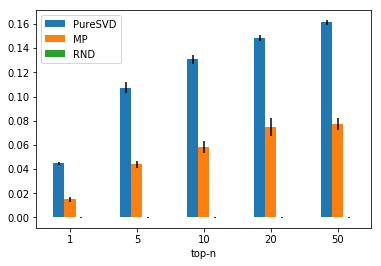

In [56]:
target_scores.plot.bar(yerr=target_erorrs, rot=0)

In [45]:
from polara.evaluation.plotting import show_ranking
from polara.evaluation.plotting import show_hit_rates

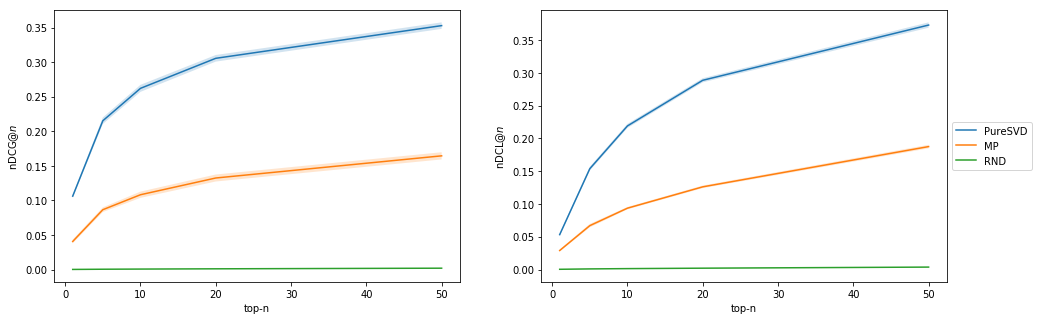

In [46]:
show_ranking(scores, errors=errors)

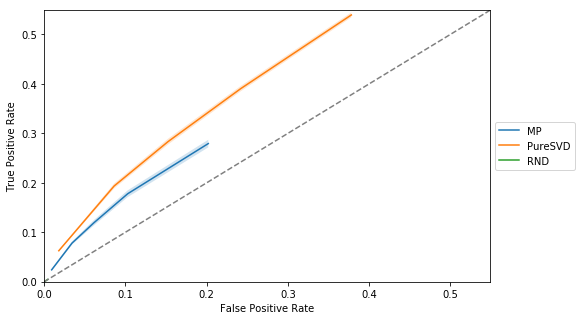

In [47]:
show_hit_rates(scores, errors=errors)